In [3]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 
from pyro_oed_src import nmc_eig

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [4]:
N = 2000 # total number of points
p = 8 # num of samples per each axis of (t_1, t_2)

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
times = np.linspace(0,2*np.pi,N)

designs = torch.tensor(times[indices])
#designs = torch.tensor(indices)
print(designs.shape[-2:])

torch.Size([64, 2])


In [5]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    w = pyro.sample("w", dist.Uniform(w_1,w_2))
    phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2))
    with pyro.plate_stack("plate", t.shape[:-1]): # create a continguous stack of plates, Pyro adds dimensions to the left
        y_true = torch.sin(w*t+phase)
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1)) # to_event: num of batch dimensions (from right) to reinterpret as event dimensions

In [6]:
n = 100
m = np.sqrt(n).astype(int)
nmc_eig_output_low, nmc_eig_output_high = nmc_eig(model, designs, ["y"], ["w", "phase"], N=n, M=m, contrastive=True)

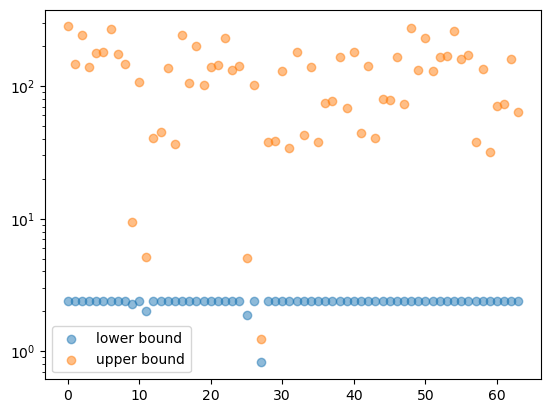

In [8]:
plt.scatter(range(len(designs)), nmc_eig_output_low, alpha=0.5, label="lower bound")
plt.scatter(range(len(designs)), nmc_eig_output_high, alpha=0.5, label="upper bound")
plt.semilogy()
plt.legend()
plt.show()

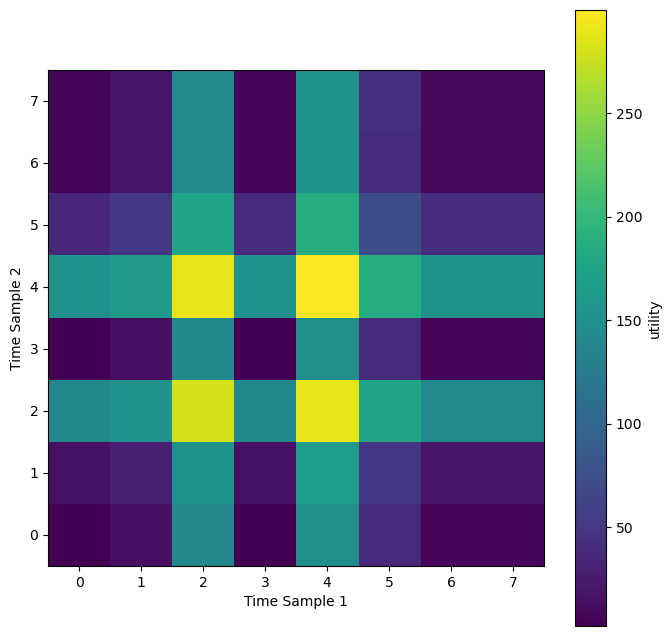

In [8]:
plt.figure(figsize=(8,8))
img_2D = plt.imshow(nmc_eig_output.reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()